In [35]:
from bs4 import BeautifulSoup
import urllib
import requests
import urllib.error
import urllib.request as ur
import pandas as pd
from datetime import datetime
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from urllib.request import Request, urlopen
import random
import matplotlib.pyplot as plt
import os
import json
import time
from matplotlib.backends.backend_pdf import PdfPages

In [44]:
def comment_scrape_new(WEBSITE, Page):
    comments = []
    rates = []
    dates = []

    # type in the website you want to scrape and analyze the trends over time!!!!!
    
    user_agents_list = [
            'Mozilla/5.0 (iPad; CPU OS 13_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_16_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
            'python-requests/3.10.0',
            'python-requests/2.14.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
            'Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1',
            'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 Edg/87.0.664.75',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363'
        ]
    

    for page in range(1, Page):
        time.sleep(random.randint(0, 3))
        if page == 1:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE + '?languages=all&sort=recency',
                    headers={'User-Agent': random.choice(user_agents_list)}
                )

        else:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE +'?languages=all&page={}&sort=recency'.format(str(page)),
                    headers={'User-Agent': random.choice(user_agents_list)}
                )
        retries = 0
        while retries < 3:
            try: 
                content = urlopen(req).read()
                break
            except urllib.error.HTTPError as e:
                time.sleep(5)
                retries += 1
        
        
        soup = BeautifulSoup(content, 'html.parser')

        table_com_date = soup.findAll('div',attrs={"class":"styles_reviewContent__0Q2Tg"})
        table_rate = soup.findAll('div',attrs={"class":"styles_reviewHeader__iU9Px"})

        # scrape rates
        for x in table_rate:
            rates.append(x['data-service-review-rating'])

        # scrape comments and dates
        for x in table_com_date:

            comments.append(x.find('p').text)
            date = x.find('p', attrs = {"class": "typography_body-m__xgxZ_ typography_appearance-default__AAY17 typography_color-black__5LYEn"}).text[20:]
            date = datetime.strptime(date , "%B %d, %Y")
            dates.append(date)
        
    d = {'Review': comments, 'Rate': rates,'Date': dates }
    df = pd.DataFrame(d)
    df = df.set_index(['Date'])
    df['Company'] = WEBSITE
    
    # print ratio
    print('Rate counts shows below:')
    print(df['Rate'].value_counts())
    print('\nRate counts ratio shows below:')
    print(df.Rate.value_counts(normalize=True))
    
    print('\nReview groupby year shows below:')
    print(df.groupby(df.index.year)['Review'].count())
    
    print('\nScraped ' + str(len(df)) + ' reviews of ' + WEBSITE)
    
    return df

In [24]:
def trends_analyze_new(filename, Rate, Date, Company):
    
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company]

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    df = df.loc[df['Rate'] == Rate].loc[Date]
    
    sentence = " ".join(df['Review'])
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]

    # #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))

    # #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)

    return word_freq, word_pairs, trigrams

In [25]:
def plot_chart_new(word_freq, word_pairs, trigrams):
    # create subplot of the different data frames
    fig, axes = plt.subplots(3,1,figsize=(9,15))
    sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
    sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
    sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))
    
    return 

In [26]:
def review_chart_plot_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.set_index(['Date'])

    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    
    
    # review_star_split
    
    fig0, axd = plt.subplot_mosaic([['ax0', 'ax0'], ['ax1', 'ax2'], ['ax3','ax3']],figsize=(15, 15))
    df.groupby([df.index.year, "Rate"]).count().unstack().plot(kind='bar', edgecolor='black',ax = axd['ax0'])
    axd['ax0'].set_title("Review Star Distribution Over Time of "+ Company)
    axd['ax0'].legend(title="")
    
    df['Rate'].plot(kind='hist', edgecolor='black',ax=axd['ax1'])
    axd['ax1'].set_title("Review Star Distribution")
    
    df_rs = df.groupby([df.index.year, "Rate"]).count()
    df_rs = df_rs.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df_rs.unstack().plot(kind='bar', stacked=True, ax=axd['ax2'])
    
    axd['ax2'].set_title("Review Star Percentage over Time")
    axd['ax2'].legend(title="")
    
    # review_volume_trend

    df_rv = df.groupby(df.index.year).count().pop('Review')
    df_rv.plot(kind='bar', stacked=True, ax=axd['ax3'])
    axd['ax3'].set_ylabel('Number of Reviews')
    axd['ax3'].set_title("Review Volume Trend")
    
    # review_pie_chart
    
    number_group = df.groupby(df.index.year).ngroups
    
    df_rp = df.groupby([df.index.year, "Rate"]).count()
    df_rp = df_rp.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    nrow = len(df_rp.index.levels[0])//4 + 1

    fig2 = plt.figure(figsize=(15, 4*nrow))
    
    for i, e in enumerate(df_rp.index.levels[0]):
        ax = fig2.add_subplot(nrow, 4, i+1)
        yy = df_rp.loc[e]["Review"].tolist()
        labels = list(df_rp.loc[e]["Review"].index.values)
        ax.pie(yy, shadow=True, startangle=90)
        labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, yy)]
        plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
        ax.set_title(e)  
    
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    
    return

In [27]:
def save_image(WEBSITE):
    filename = 'trustpilot_reviews_' + WEBSITE + '.pdf'

    p = PdfPages(filename)
    
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 

    # close the object
    p.close()  

In [ ]:
# Single Company (1)

WEBSITE = 'lendingclub.com'
Page = 229
df = comment_scrape_new(WEBSITE, Page)
df.to_csv('review_trustpilot_{}.csv'.format(WEBSITE))

In [ ]:
# Single Company (2)

filename = 'review_trustpilot_LendingClub.csv'
Company = 'LendingClub'
review_chart_plot_new(filename, Company)
save_image(Company)

In [40]:
WEBSITE = ['lendingclub.com', 'www.prosper.com', 'upgrade.com', 'www.upstart.com', 'avant.com']
Page = [229, 542, 1856, 2016, 1156]

df_bag = pd.DataFrame()

for i in range(len(WEBSITE)):
    df = comment_scrape_new(WEBSITE[i], Page[i])
    df_bag = pd.concat([df_bag, df])
    
df_bag.to_csv('review_trustpilot.csv')

Rate counts shows below:
5    19129
4     2343
1      986
3      557
2      285
Name: Rate, dtype: int64

Rate counts ratio shows below:
5    0.820987
4    0.100558
1    0.042318
3    0.023906
2    0.012232
Name: Rate, dtype: float64

Review groupby year shows below:
Date
2014     760
2015     714
2016     565
2017    1995
2018    3087
2019    1981
2020    4529
2021    4964
2022    4342
2023     363
Name: Review, dtype: int64

Scraped 23300 reviews of avant.com


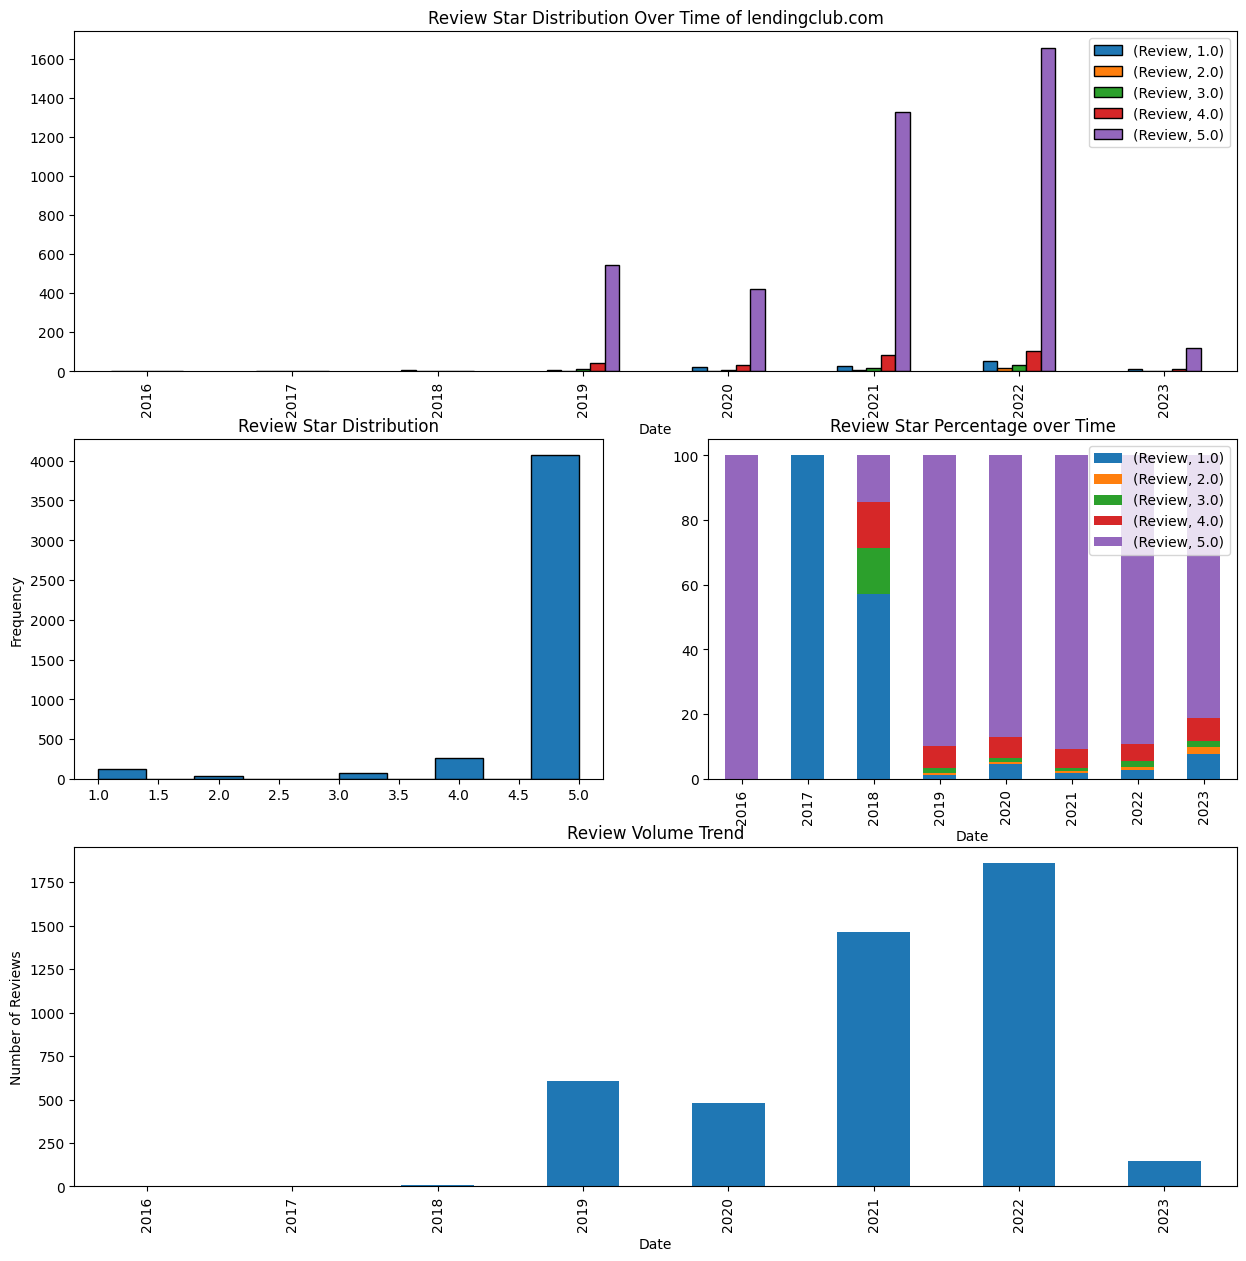

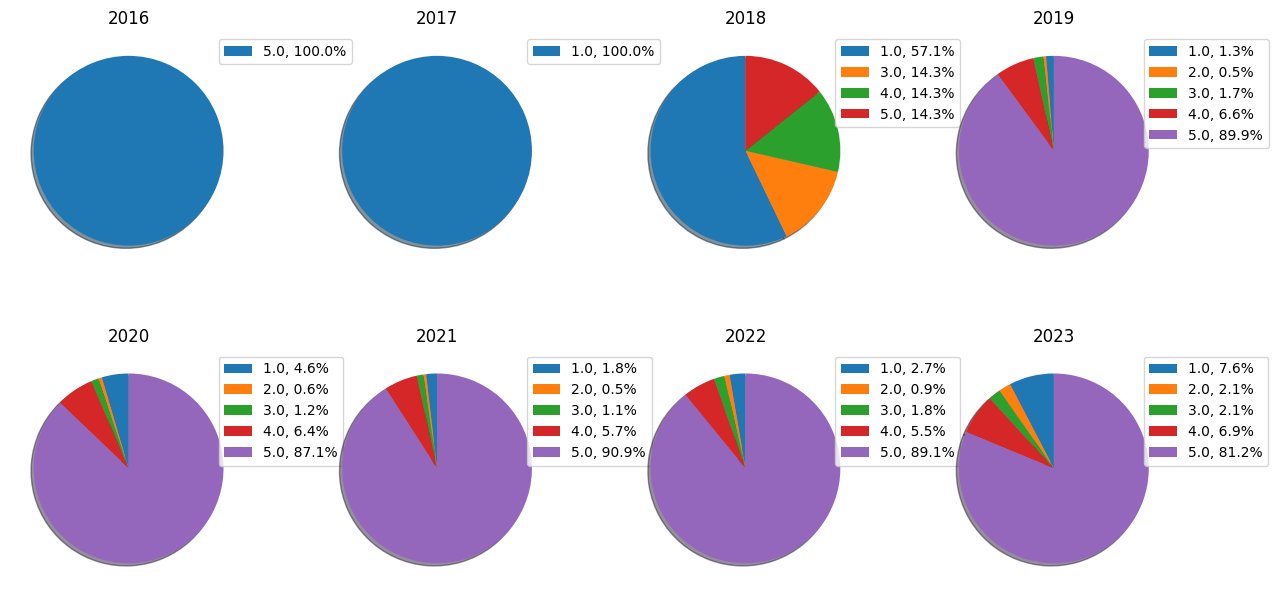

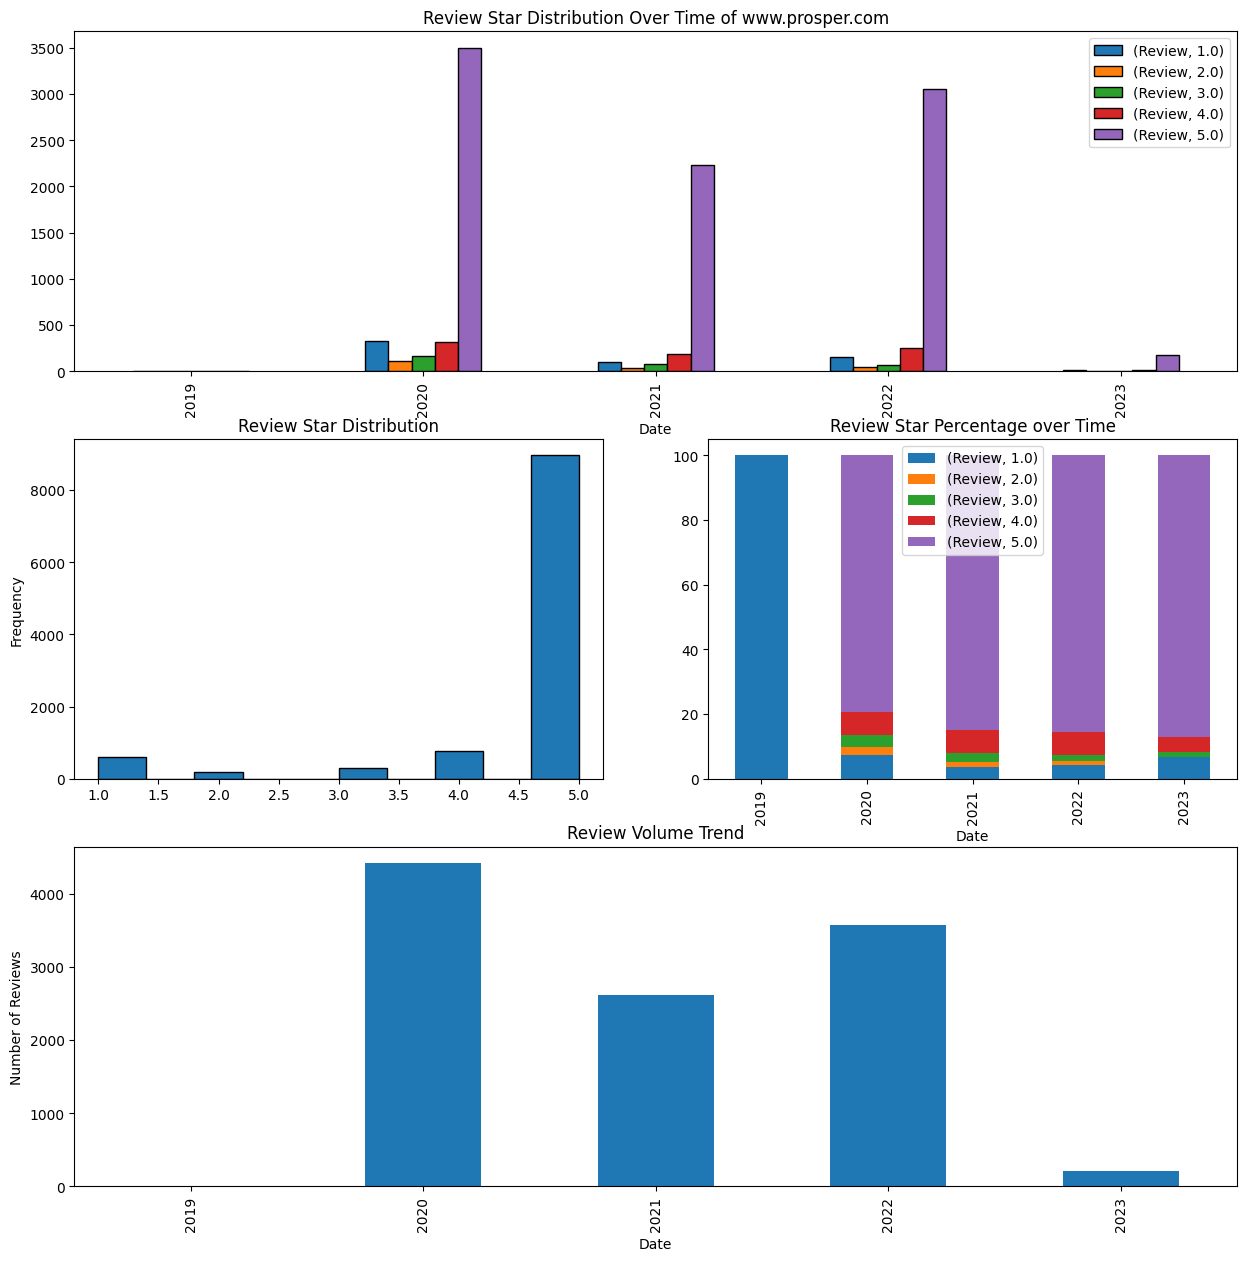

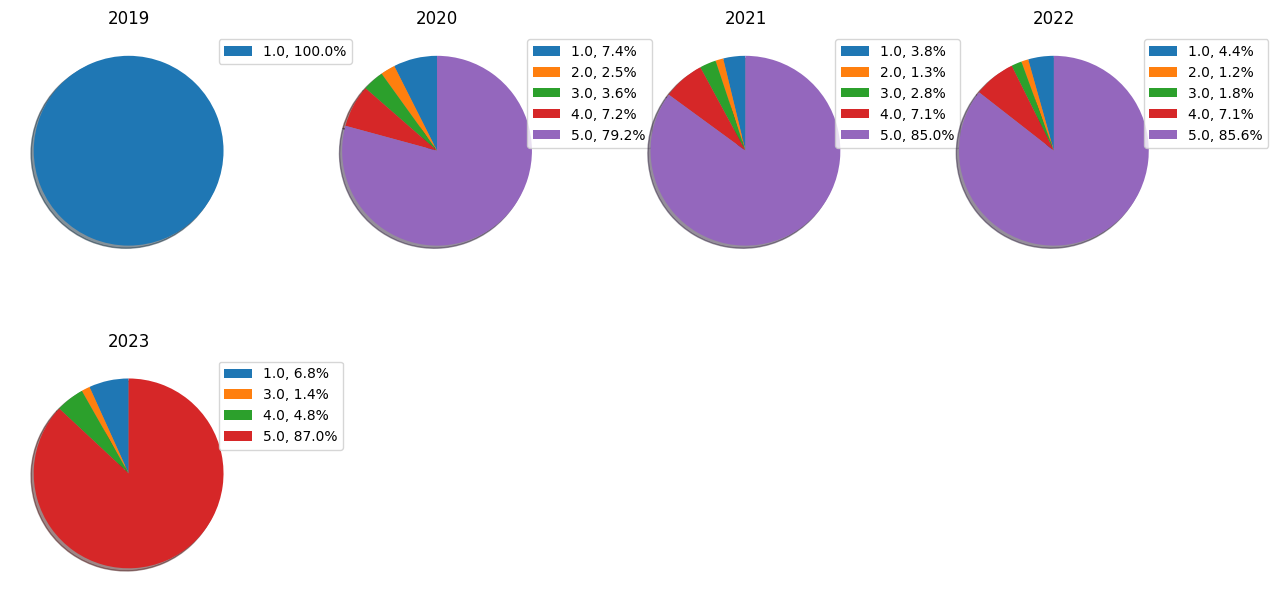

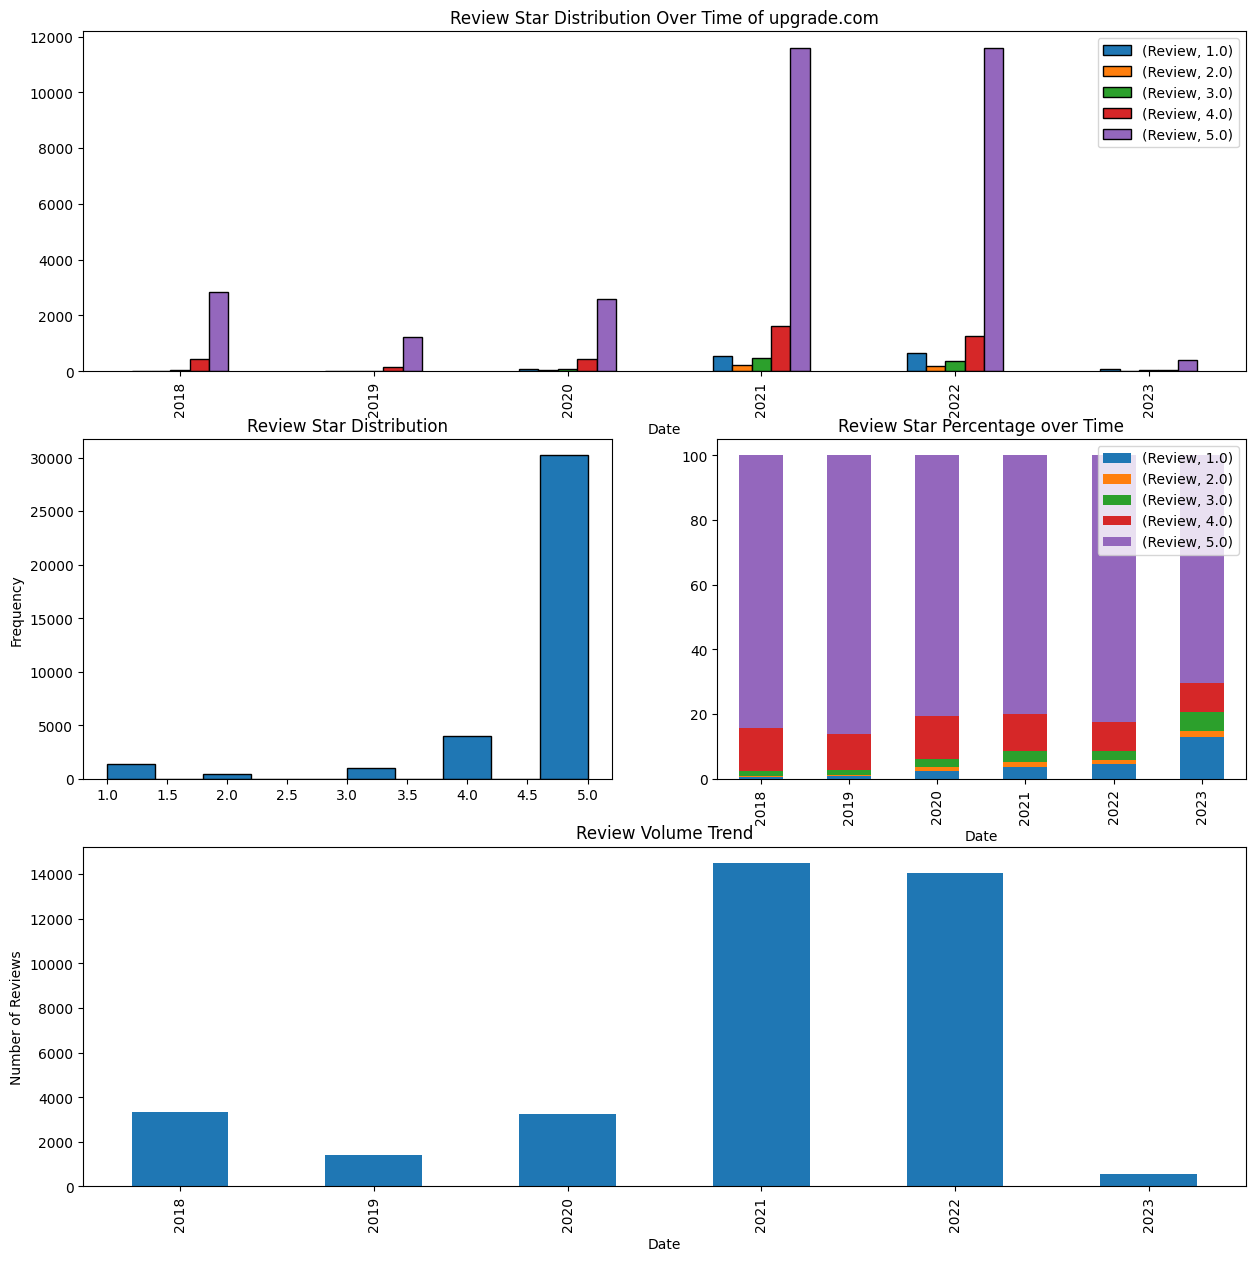

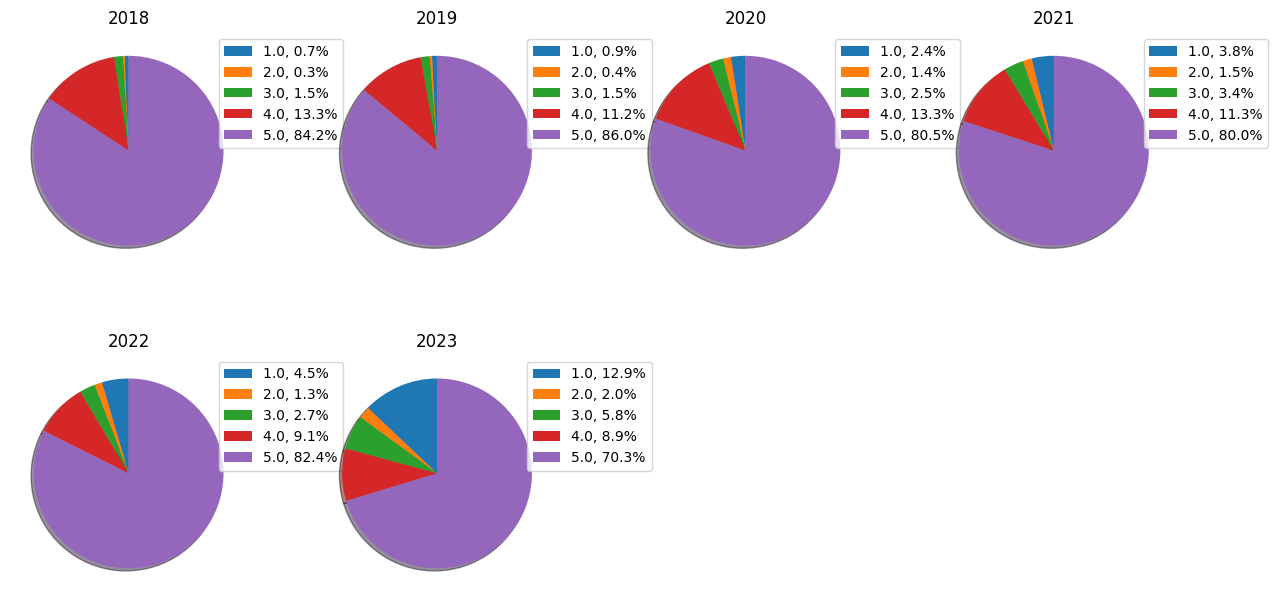

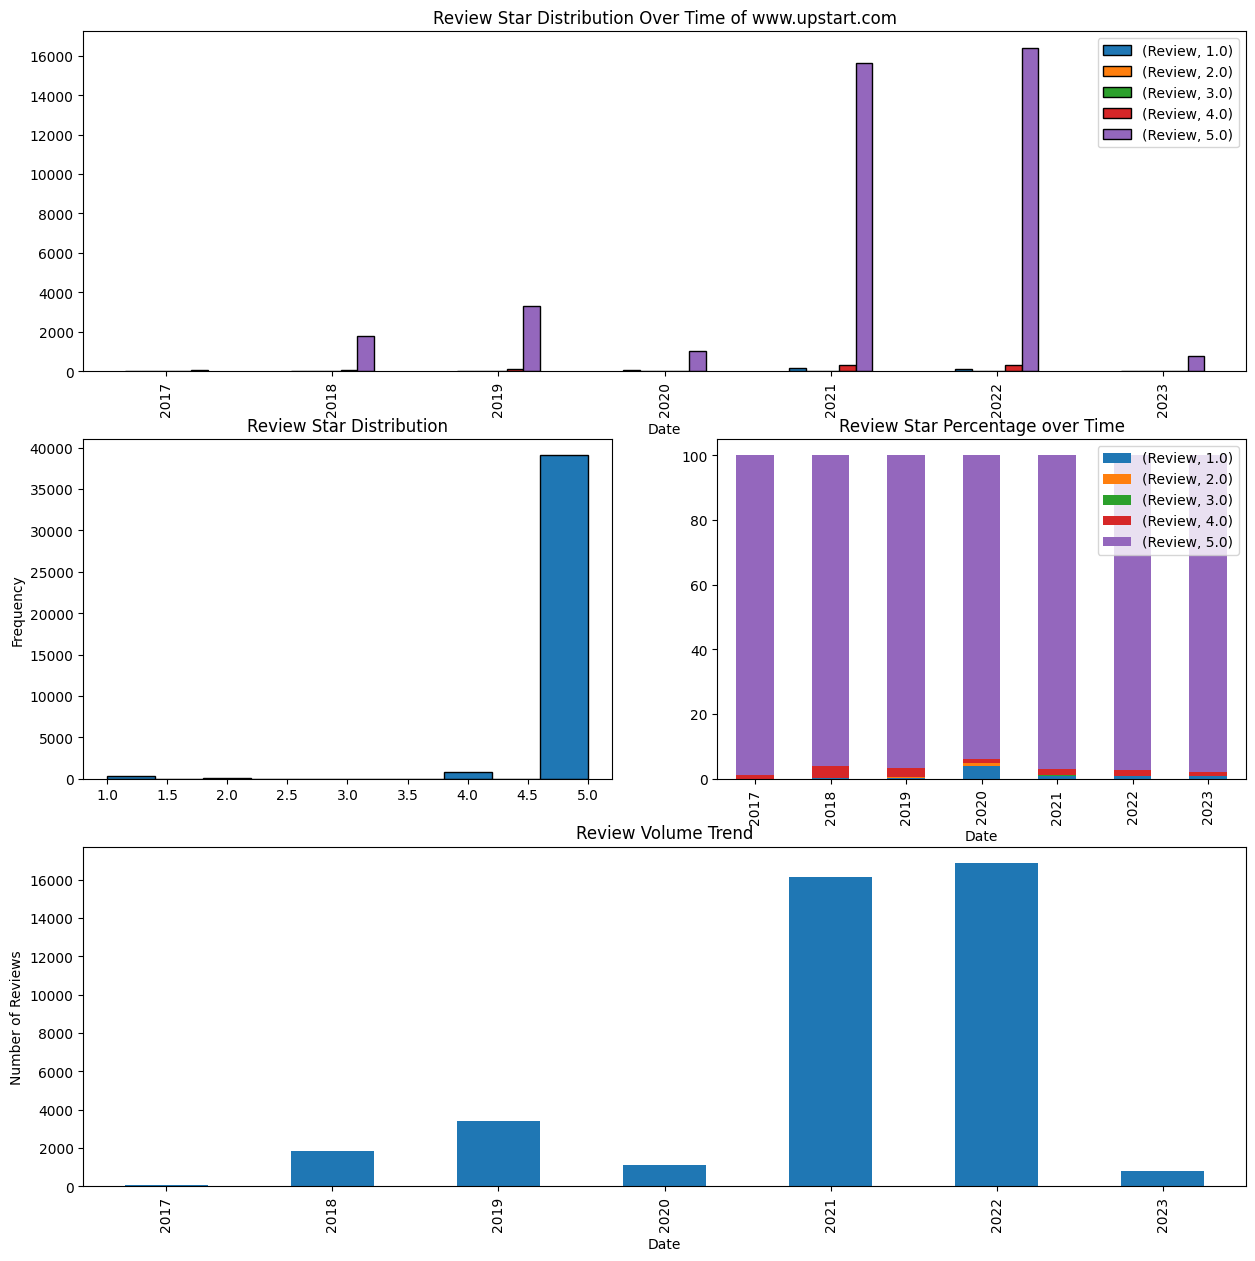

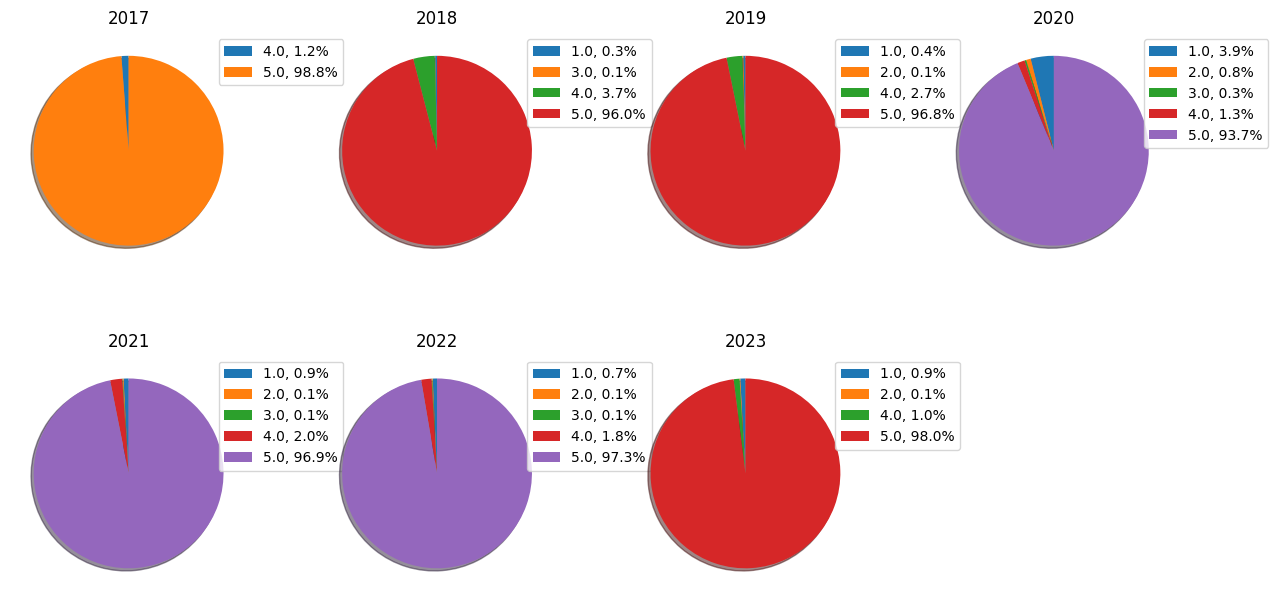

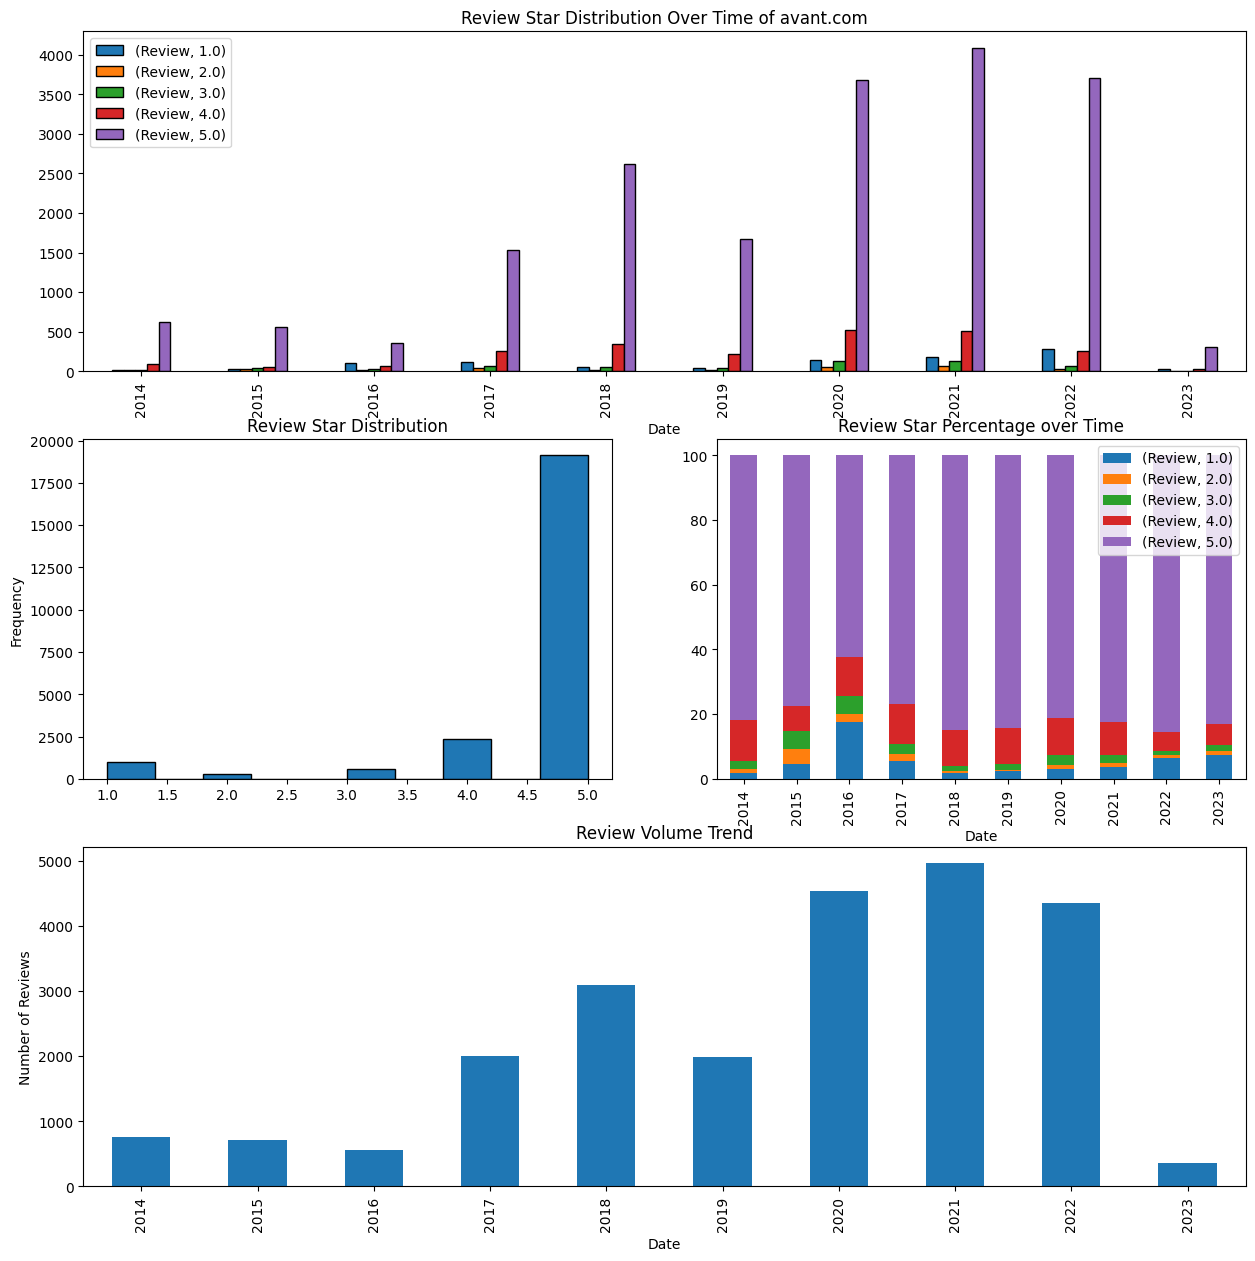

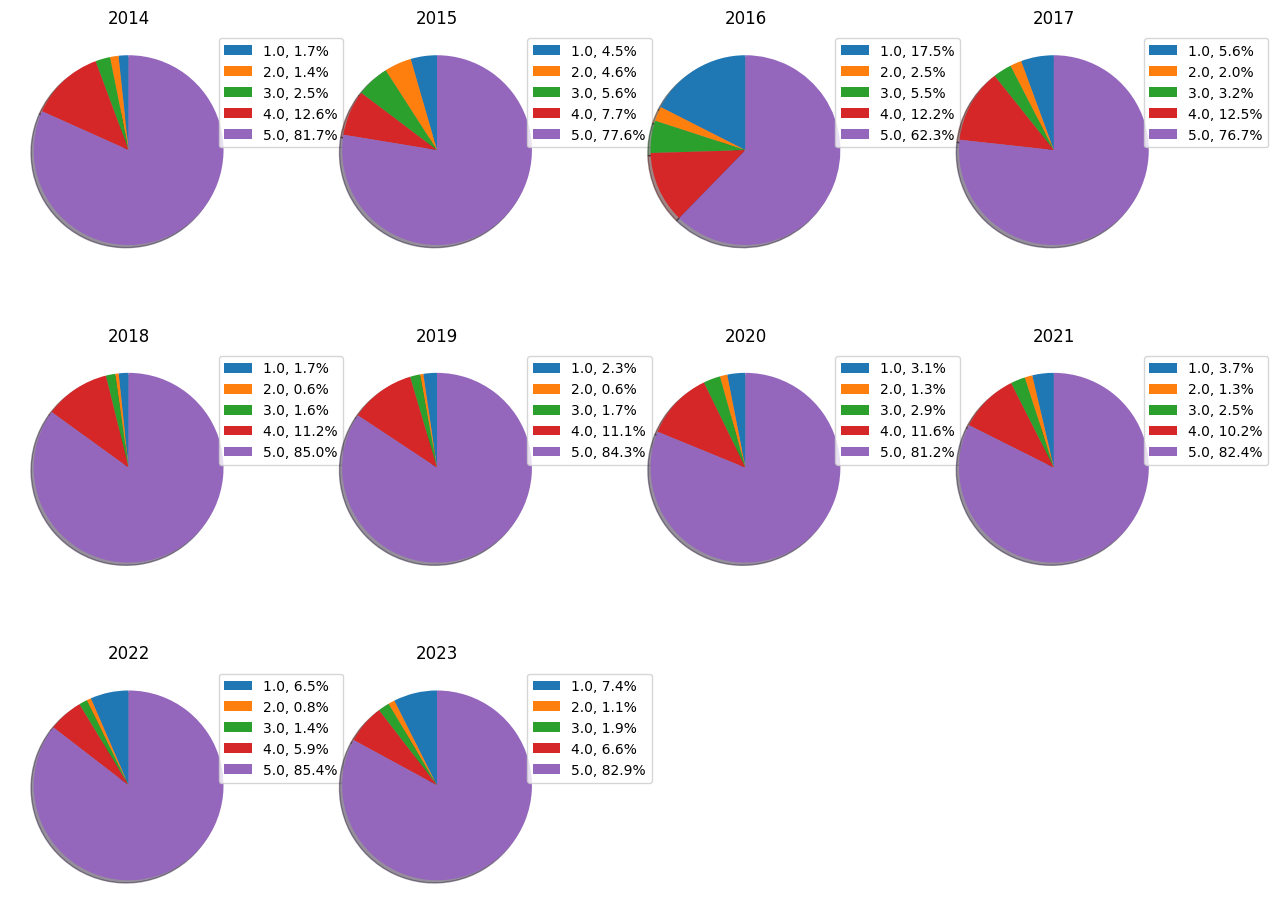

In [43]:
filename = 'review_trustpilot.csv'
WEBSITE = ['lendingclub.com', 'www.prosper.com', 'upgrade.com', 'www.upstart.com', 'avant.com']
for i in WEBSITE:
    review_chart_plot_new(filename, i)
    save_image(i)